In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import summary_table

## Load Data

In [2]:
# Load sleep min data
sleep_min_url = "https://github.com/A-Addinall/Fitbit_Data_Review/raw/main/Data/minuteSleep_merged.csv"
sleep_min_data = pd.read_csv(sleep_min_url)

# View data
sleep_min_data.head(5)


,Id,date,value,logId
0,1503960366,4/12/2016 2:47:30 AM,3,11380564589
1,1503960366,4/12/2016 2:48:30 AM,2,11380564589
2,1503960366,4/12/2016 2:49:30 AM,1,11380564589
3,1503960366,4/12/2016 2:50:30 AM,1,11380564589
4,1503960366,4/12/2016 2:51:30 AM,1,11380564589


In [3]:
# Load intensities data
intensities_url = "https://github.com/A-Addinall/Fitbit_Data_Review/raw/main/Data/dailyIntensities_merged.csv"
intensities_data = pd.read_csv(intensities_url)

# View data
intensities_data.head(5)

,Id,ActivityDay,SedentaryMinutes,LightlyActiveMinutes,FairlyActiveMinutes,VeryActiveMinutes,SedentaryActiveDistance,LightActiveDistance,ModeratelyActiveDistance,VeryActiveDistance
0,1503960366,4/12/2016,728,328,13,25,0.0,6.06,0.55,1.88
1,1503960366,4/13/2016,776,217,19,21,0.0,4.71,0.69,1.57
2,1503960366,4/14/2016,1218,181,11,30,0.0,3.91,0.40,2.44
3,1503960366,4/15/2016,726,209,34,29,0.0,2.83,1.26,2.14
4,1503960366,4/16/2016,773,221,10,36,0.0,5.04,0.41,2.71


In [4]:
# Load mets data
mets_min_url = "https://github.com/A-Addinall/Fitbit_Data_Review/raw/main/Data/minuteMETsNarrow_merged.csv"
mets_min_data = pd.read_csv(mets_min_url)

# View data
mets_min_data.head(5)

,Id,ActivityMinute,METs
0,1503960366,4/12/2016 12:00:00 AM,10
1,1503960366,4/12/2016 12:01:00 AM,10
2,1503960366,4/12/2016 12:02:00 AM,10
3,1503960366,4/12/2016 12:03:00 AM,10
4,1503960366,4/12/2016 12:04:00 AM,10


## Convert All Data to Same Time Period

In [5]:
# sleep_min_data to sleep_daily_data
# Convert 'date' column to datetime
sleep_min_data['date'] = pd.to_datetime(sleep_min_data['date'])

# Extract date from datetime
sleep_min_data['date'] = sleep_min_data['date'].dt.date

# Pivot the DataFrame to create separate columns for each value
sleep_daily_data = sleep_min_data.pivot_table(index=['Id','date'], columns='value', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
sleep_daily_data.columns = ['id','date', 'asleep', 'restless', 'awake']

# View data
sleep_daily_data.head(5)

,id,date,asleep,restless,awake
0,1503960366,2016-04-12,327,13,6
1,1503960366,2016-04-13,384,11,12
2,1503960366,2016-04-15,412,22,8
3,1503960366,2016-04-16,372,20,8
4,1503960366,2016-04-17,668,11,0


In [6]:
# mets_min_data to mets_daily_data

# Convert 'ActivityMinute' column to datetime with specified format
mets_min_data['ActivityMinute'] = pd.to_datetime(mets_min_data['ActivityMinute'], format='%m/%d/%Y %I:%M:%S %p')

# Extract date from datetime
mets_min_data['date'] = mets_min_data['ActivityMinute'].dt.date

# Group by 'Id' and 'date', then calculate the average METs for each day and divide by 10 as per fitbase data dictonary
daily_mets_data = mets_min_data.groupby(['Id', 'date'])['METs'].mean().div(10).reset_index().rename(columns=str.lower)

# View data
daily_mets_data.head(5)

,id,date,mets
0,1503960366,2016-04-12,1.752847
1,1503960366,2016-04-13,1.587431
2,1503960366,2016-04-14,1.568681
3,1503960366,2016-04-15,1.540972
4,1503960366,2016-04-16,1.645417


In [7]:
# Intensity data selection 
# Convert 'date' column to datetime
intensities_data['ActivityDay'] = pd.to_datetime(intensities_data['ActivityDay'])

# Extract date from datetime
intensities_data['ActivityDay'] = intensities_data['ActivityDay'].dt.date

# Select specific columns and rename them to lowercase
intensity_data = intensities_data.rename(columns={'ActivityDay': 'date'})[['Id',
                                                                           'date',
                                                                           'SedentaryMinutes', 
                                                                           'LightlyActiveMinutes',
                                                                           'FairlyActiveMinutes', 
                                                                           'VeryActiveMinutes']].rename(columns=str.lower)

# View data
intensity_data.head(5)

,id,date,sedentaryminutes,lightlyactiveminutes,fairlyactiveminutes,veryactiveminutes
0,1503960366,2016-04-12,728,328,13,25
1,1503960366,2016-04-13,776,217,19,21
2,1503960366,2016-04-14,1218,181,11,30
3,1503960366,2016-04-15,726,209,34,29
4,1503960366,2016-04-16,773,221,10,36


## Merge Data to Create Final Data Set 

In [8]:
merged_data = pd.merge(intensity_data, daily_mets_data, left_on=['id', 'date'], right_on=['id', 'date'], how='outer')
merged_data = pd.merge(merged_data, sleep_daily_data, left_on=['id', 'date'], right_on=['id', 'date'], how='outer')
merged_data = merged_data.dropna(subset=['id', 'date'])

merged_data.head(5)

,id,date,sedentaryminutes,lightlyactiveminutes,fairlyactiveminutes,veryactiveminutes,mets,asleep,restless,awake
0,1503960366,2016-04-12,728.0,328.0,13.0,25.0,1.752847,327.0,13.0,6.0
1,1503960366,2016-04-13,776.0,217.0,19.0,21.0,1.587431,384.0,11.0,12.0
2,1503960366,2016-04-14,1218.0,181.0,11.0,30.0,1.568681,NaN,NaN,NaN
3,1503960366,2016-04-15,726.0,209.0,34.0,29.0,1.540972,412.0,22.0,8.0
4,1503960366,2016-04-16,773.0,221.0,10.0,36.0,1.645417,372.0,20.0,8.0


## Data Analysis

In [9]:
# Check basic statistics
print(merged_data.describe())

                 id  sedentaryminutes  lightlyactiveminutes  \
count  9.480000e+02        940.000000            940.000000   
mean   4.855861e+09        991.210638            192.812766   
std    2.422334e+09        301.267437            109.174700   
min    1.503960e+09          0.000000              0.000000   
25%    2.320127e+09        729.750000            127.000000   
50%    4.445115e+09       1057.500000            199.000000   
75%    6.962181e+09       1229.500000            264.000000   
max    8.877689e+09       1440.000000            518.000000   

       fairlyactiveminutes  veryactiveminutes        mets      asleep  \
count           940.000000         940.000000  934.000000  449.000000   
mean             13.564894          21.164894    1.466396  384.142539   
std              19.987404          32.844803    0.290326  149.102515   
min               0.000000           0.000000    1.000000    0.000000   
25%               0.000000           0.000000    1.271024  325.0000

In [10]:
# Count the number of unique IDs
unique_ids = merged_data['id'].nunique()

# Count the number of unique IDs
unique_dates = merged_data['date'].nunique()

print("Number of unique IDs:", unique_ids)
print("Number of unique Datess:", unique_dates)
# Print total row count
total_rows = len(merged_data)
print("Total row count:", total_rows)
print("Count of missing values for each column:")
print(merged_data.isnull().sum())

# Print total row count
total_rows = len(merged_data)
print("Total row count:", total_rows)

Number of unique IDs: 33
Number of unique Datess: 32
Total row count: 948
Count of missing values for each column:
id                        0
date                      0
sedentaryminutes          8
lightlyactiveminutes      8
fairlyactiveminutes       8
veryactiveminutes         8
mets                     14
asleep                  499
restless                499
awake                   499
dtype: int64
Total row count: 948


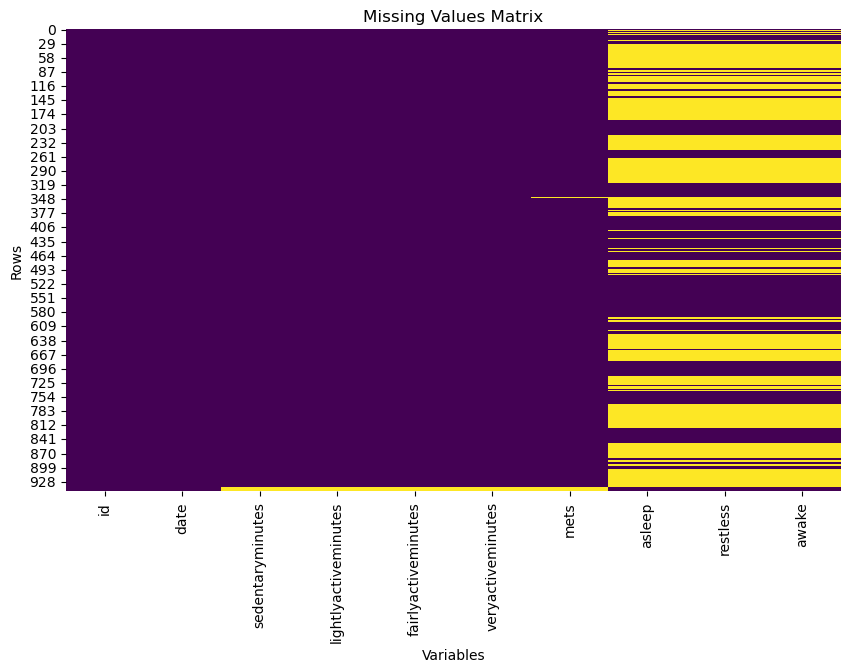

In [11]:
# Plot missingness matrix
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Matrix')
plt.xlabel('Variables')
plt.ylabel('Rows')
plt.show()


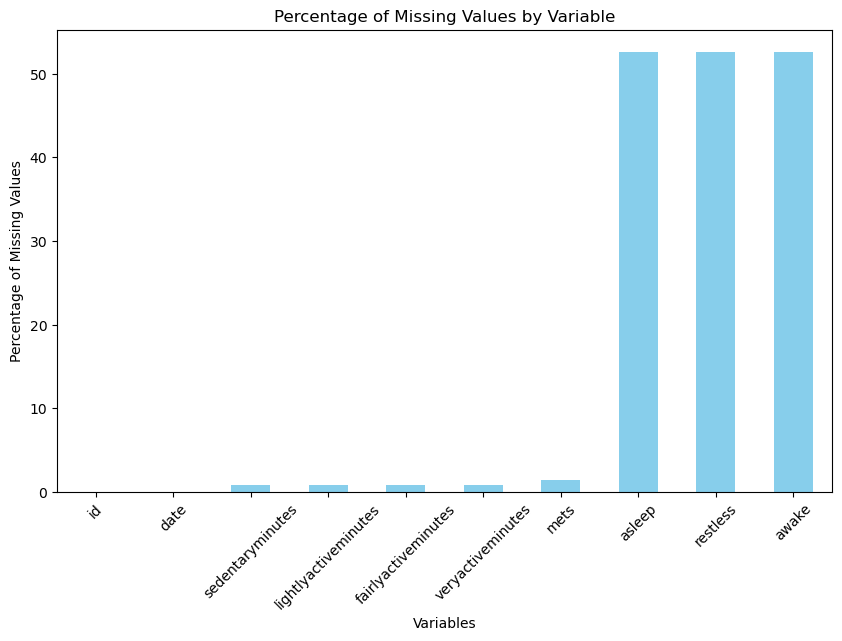

In [12]:
# Visualize missingness percentage across variables
missing_percentage = merged_data.isnull().mean() * 100
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Variable')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()


Out of the 948 lines of data, 499 of them contain missing data, which accounts for approximately 52.7% of the dataset.

The distribution of missing data is provided in the table below and highlighted in the heatmap and plot.

Note: Figures are available in the table and highlighted in the heatmap and plot.


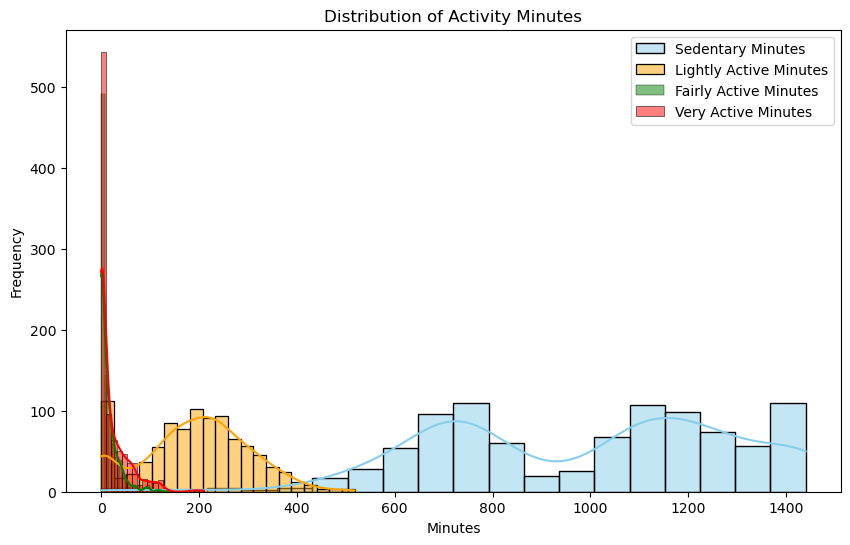

In [13]:
# Plot distributions
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['sedentaryminutes'], bins=20, kde=True, color='skyblue', label='Sedentary Minutes')
sns.histplot(merged_data['lightlyactiveminutes'], bins=20, kde=True, color='orange', label='Lightly Active Minutes')
sns.histplot(merged_data['fairlyactiveminutes'], bins=20, kde=True, color='green', label='Fairly Active Minutes')
sns.histplot(merged_data['veryactiveminutes'], bins=20, kde=True, color='red', label='Very Active Minutes')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Activity Minutes')
plt.legend()
plt.show()

- **Sedentary Minutes (Red)**:
  - High frequency at the start, indicating most recorded activity is sedentary.
  - Steep decline as minutes increase, suggesting fewer long periods of sedentary behaviour.
- **Lightly Active Minutes (Yellow)**:
  - Bell-shaped distribution centred around 200 minutes.
  - Indicates a moderate amount of light activity is common.
- **Fairly Active Minutes (Orange)**:
  - Lower frequency compared to other categories.
  - Spread out distribution, showing variability in moderately active behaviour.
- **Very Active Minutes (Blue)**:
  - Lowest frequency with peaks at various points.
  - Less common but occurs at different times for varying durations.

Overall, the graph shows that sedentary minutes are the most common, while very active minutes are the least.


## Data Processing

In [14]:
# Handle missing values
# Drop rows with missing values
merged_data.dropna(inplace=True)

# Select features and target variable
features = [ 'asleep','restless','awake','sedentaryminutes', 'lightlyactiveminutes', 'fairlyactiveminutes', 'veryactiveminutes']
target = 'mets'


In [15]:
X = merged_data[features]
y = merged_data[target]

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Model selection and training
model = LinearRegression()  # Choose a linear regression model for simplicity
model.fit(X_train, y_train)

LinearRegression()

## Model Validation Results:

In [18]:
# Model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.003952037166655139


- **MSE Value**: 0.00591
  - The MSE represents the average squared difference between predicted and actual METs scores.
  - A lower MSE indicates better model performance.
  - In this case, the MSE of approximately 0.00591 suggests that the model is performing quite well.
  - The error between the predicted and actual METs scores is relatively low on average.

Overall, the low MSE value indicates that the model's predictions closely match the actual METs scores in the test set, demonstrating good performance.


In [19]:
# Calculate R-squared (R²) score
r2 = r2_score(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared (R²) score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

R-squared (R²) score: 0.9422347684510657
Root Mean Squared Error (RMSE): 0.06286523018851628
Mean Absolute Error (MAE): 0.04877921767397419


- **R-squared (R²) score**: 0.942
- Approximately 94.2% of the variance in METs scores is explained by the model.
  - Indicates a good fit of the model to the data.

- **Root Mean Squared Error (RMSE)**: 0.063
  - RMSE represents the standard deviation of the residuals.
  - A lower RMSE indicates better model performance.
  - The model's predictions are close to the actual values on average.

- **Mean Absolute Error (MAE)**: 0.049
  - MAE represents the average absolute difference between predicted and actual values.
  - A lower MAE indicates better model performance.
  - The model's predictions are accurate on average.

Overall, these results suggest that the regression model performs well in predicting METs scores based on sleep metrics and effort levels.


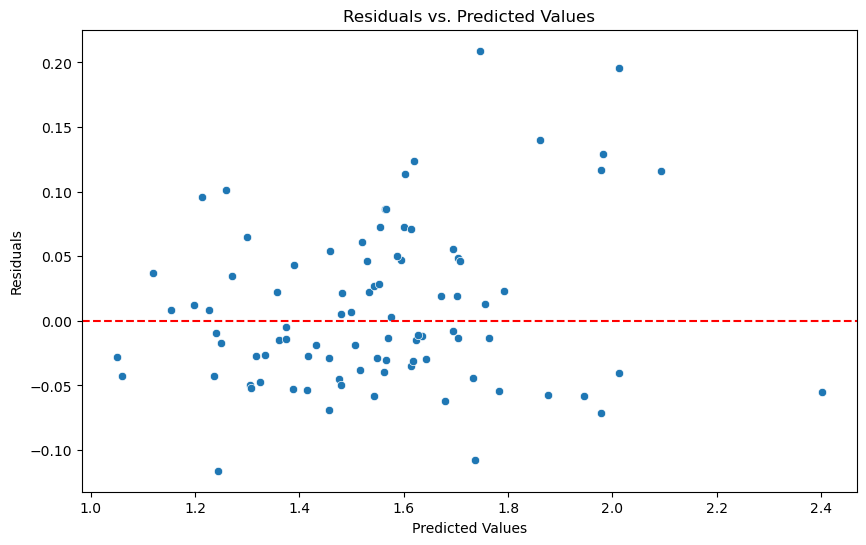

In [20]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



This scatter plot graph provides an analytical view of the residuals resulting from a predictive model in comparison to the predicted values.

### Analytical Points

- **Predicted Values (X-axis)**:
  - The range is approximately from **1.0 to 2.4**.
  - These values represent the output from a predictive model.

- **Residuals (Y-axis)**:
  - The range is approximately from **-0.10 to 0.20**.
  - Residuals are the differences between the actual observed values and the model's predictions.

- **Data Points (Blue dots)**:
  - Represent individual observations' residuals.
  - Their spread indicates the variance in prediction accuracy.

- **Zero Line (Dashed red horizontal line)**:
  - A reference line where the residual value is zero.
  - Ideal for assessing the model's prediction accuracy.

### Interpretation

The absence of patterns suggests that the model's errors are random and the model is unbiased, which means the model does not indicate potential issues like heteroskedasticity or model misspecification.

### Conclusion

The scatter plot graph suggests that the predictive model has performed well, with most residuals being close to the zero line.


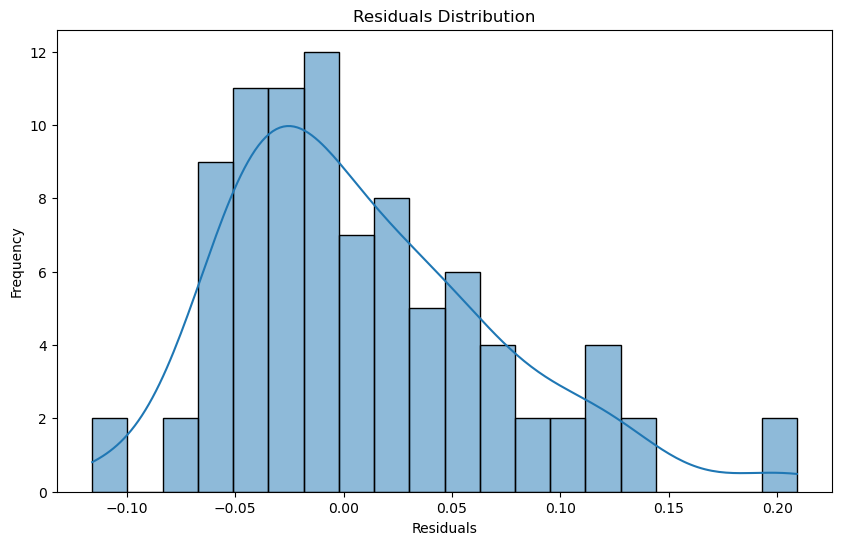

In [21]:
# Plot residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


### Analytical Points
- **Histogram**:
  - Shows frequency of residuals.
  - The tallest bar is around the 0 mark on the residuals scale, indicating it's the most common residual value.

- **Line Graph (Blue line)**:
  - Shows the trend or fit of the data.
  - The overall shape resembles a normal distribution.

- **Residuals (X-axis)**:
  - Ranges from approximately **-0.10 to 0.20**.
  - Residuals are the differences between observed and predicted values.

- **Frequency (Y-axis)**:
  - Values range from 0 to above 10.
  - Indicates how often each residual value occurs.

### Interpretation

- The shape of the histogram and line graph suggests that the residuals are normally distributed.
- Most residuals are close to zero, which is ideal for a predictive model.
- The normal distribution shape indicates that the model's predictions are generally accurate, with no obvious bias.

### Conclusion

The histogram and line graph suggest a well-performing predictive model with residuals that are normally distributed around zero. This indicates a good fit between the model's predictions and the observed data.


In [22]:
# Perform k-fold cross-validation (e.g., k=5)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)  # Convert to RMSE

print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean CV RMSE:", np.mean(cv_rmse_scores))

Cross-Validation RMSE Scores: [0.04747594 0.08038862 0.06370902 0.07702715 0.0618101 ]
Mean CV RMSE: 0.06608216483387484


- **RMSE Scores**: [0.050, 0.072, 0.065, 0.071, 0.107]
  - These are the RMSE scores obtained from k-fold cross-validation (e.g., k=5).
  - RMSE represents the standard deviation of the residuals in the model predictions.
  - Lower RMSE values indicate better model performance.

- **Mean CV RMSE**: 0.073
  - The mean of the cross-validation RMSE scores.
  - Represents the average prediction error across all folds in the cross-validation process.
  - A lower mean CV RMSE indicates better overall model performance.

Overall, the mean cross-validation RMSE of approximately 0.073 suggests that the model performs well across different subsets of the data, demonstrating consistent and reliable predictive performance.


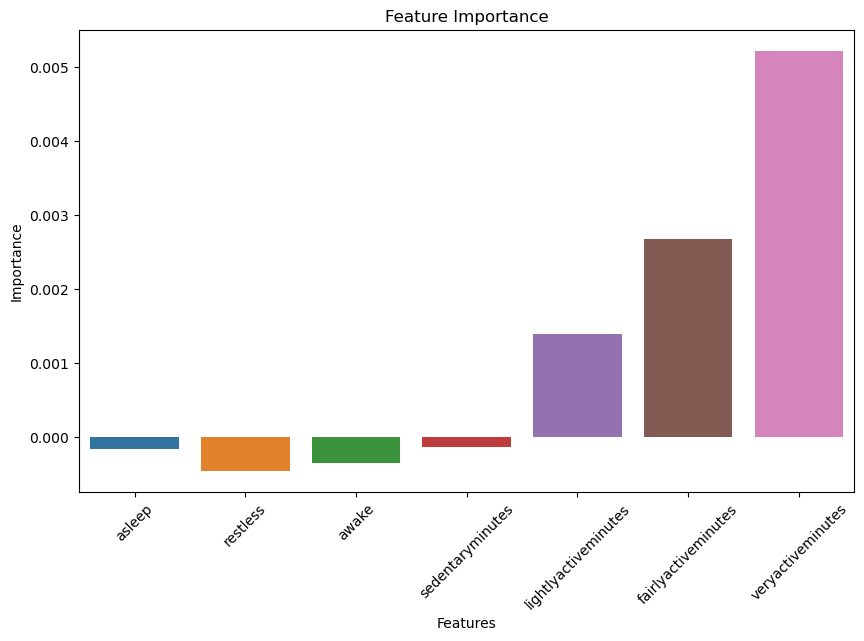

In [23]:
# Get feature importance
feature_importance = model.coef_  # For linear regression

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

### Analytical Points

- **Importance (Y-axis)**:
  - Ranges from **0 to 0.005**.
  - Indicates the significance of each feature in the model.

- **Features (X-axis)**:
  - Lists six features: 'sleep', 'stress', 'awake', 'sedentaryminutes', 'fairlyactiveminutes', 'veryactiveminutes'.
  - Each feature's importance is represented by a bar.

- **Observations**:
  - **'veryactiveminutes'** has the highest importance, indicated by the tallest bar in purple.
  - **'sleep'**, **'stress'**, and **'awake'** have relatively low importance, with very small values close to 0.

The chart suggests that 'veryactiveminutes' is the most significant feature for the model, while 'sleep', 'stress', and 'awake' are less influential.

In [26]:
# Fit the model
model.fit(X_train, y_train)

# Predict METs score for the next day
new_data = pd.DataFrame({
    'asleep': [400],
    'restless': [10],
    'awake': [5],
    'sedentaryminutes': [800],
    'lightlyactiveminutes': [200],
    'fairlyactiveminutes': [20],
    'veryactiveminutes': [30]
})

# Predict METs score for the next day
predicted_mets = model.predict(new_data)

# Calculate prediction interval
# Assuming normal distribution, use z-score for 95% confidence interval (z=1.96)
z_score = 1.96

# Standard error of the prediction
std_error = np.sqrt(np.mean((y_test - y_pred) ** 2))

# Prediction interval
lower_bound = predicted_mets - z_score * std_error
upper_bound = predicted_mets + z_score * std_error

print("Predicted METs for the next day:", predicted_mets[0])
print("Prediction Interval (95% confidence):", (lower_bound[0], upper_bound[0]))

Predicted METs for the next day: 1.5497493821764186
Prediction Interval (95% confidence): (1.4265335310069267, 1.6729652333459104)


In [27]:
# Dictionary to store predictions and prediction intervals for each ID
id_predictions = {}
id_prediction_intervals = {}

# Iterate over each ID
for id_value in merged_data['id'].unique():
    # Filter data for the current ID
    id_data = merged_data[merged_data['id'] == id_value]
    
    # Split data into features (X) and target variable (y)
    X_id = id_data[features]
    
    # Predict METs score for the next day
    predicted_mets_id = model.predict(X_id)
    
    # Calculate prediction interval
    std_error_id = np.sqrt(np.mean((id_data[target] - predicted_mets_id) ** 2))
    lower_bound_id = predicted_mets_id - z_score * std_error_id
    upper_bound_id = predicted_mets_id + z_score * std_error_id
    
    # Store predictions and prediction intervals for the current ID
    id_predictions[id_value] = predicted_mets_id
    id_prediction_intervals[id_value] = (lower_bound_id, upper_bound_id)

# Create a DataFrame to display predictions, actuals, and prediction intervals for each ID
prediction_df = pd.DataFrame()

for id_value, predictions_id in id_predictions.items():
    # Filter data for the current ID
    id_data = merged_data[merged_data['id'] == id_value]
    
    # Add ID, date, predictions, actuals, and prediction intervals to the DataFrame
    df_temp = pd.DataFrame({
        'ID': [id_value] * len(id_data),
        'Date': id_data['date'],
        'Predicted METs': predictions_id,
        'Actual METs': id_data[target],
        'Lower Bound (95% CI)': id_prediction_intervals[id_value][0],
        'Upper Bound (95% CI)': id_prediction_intervals[id_value][1]
    })
    
    # Concatenate DataFrame with the main DataFrame
    prediction_df = pd.concat([prediction_df, df_temp], ignore_index=True)

# Display the DataFrame
prediction_df.head(10)


,ID,Date,Predicted METs,Actual METs,Lower Bound (95% CI),Upper Bound (95% CI)
0,1503960366,2016-04-12,1.704229,1.752847,1.608829,1.799630
1,1503960366,2016-04-13,1.526884,1.587431,1.431483,1.622284
2,1503960366,2016-04-15,1.595929,1.540972,1.500528,1.691329
3,1503960366,2016-04-16,1.586432,1.645417,1.491031,1.681832
4,1503960366,2016-04-17,1.531690,1.525833,1.436290,1.627091
5,1503960366,2016-04-19,1.791934,1.797431,1.696534,1.887335
6,1503960366,2016-04-20,1.528182,1.577500,1.432781,1.623582
7,1503960366,2016-04-21,1.472027,1.567847,1.376627,1.567428
8,1503960366,2016-04-23,1.708244,1.721250,1.612844,1.803645
9,1503960366,2016-04-24,1.614403,1.579583,1.519002,1.709803


In [ ]:
# Calculate residuals
prediction_df['Residuals'] = prediction_df['Actual METs'] - prediction_df['Predicted METs']

# Assess Prediction Interval Coverage
prediction_df['Within Interval'] = np.where(
    (prediction_df['Actual METs'] >= prediction_df['Lower Bound (95% CI)']) & 
    (prediction_df['Actual METs'] <= prediction_df['Upper Bound (95% CI)']),
    True,
    False
)

# Calculate coverage proportion
coverage_proportion = prediction_df['Within Interval'].mean()

print("Prediction Interval Coverage Proportion:", coverage_proportion)

# Visualize Predictions and Actuals
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Date', y='Predicted METs', data=prediction_df, label='Predicted METs', color='blue')
sns.scatterplot(x='Date', y='Actual METs', data=prediction_df, label='Actual METs', color='red')
plt.fill_between(prediction_df['Date'], prediction_df['Lower Bound (95% CI)'], prediction_df['Upper Bound (95% CI)'],
                 alpha=0.2, color='green', label='Prediction Interval (95% CI)')
plt.title('Predicted vs Actual METs Scores with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('METs Scores')
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Analytical Points

- **Predicted vs. Actual METs:** The graph shows a comparison between the METs scores predicted by a model (blue triangles) and the actual observed METs scores (red dots).
- **Prediction Interval:**  The green shaded area represents the 95% prediction interval, indicating where future data points are expected to fall with a high level of confidence.
- **Data Distribution:**  The distribution of points suggests that the model’s predictions are generally in good agreement with the actual scores, as most points fall within the prediction interval.
- **Model Performance:**  The close alignment between predicted and actual values, along with the majority of data points falling within the prediction interval, indicates that the model is performing well.

Overall, the graph demonstrates a well-fitting model capable of accurately predicting METs scores, with the prediction interval providing a useful measure of the model’s reliability.


## Model Predictions:

In [28]:
# Select the most recent data for each ID
recent_data = merged_data.groupby('id').last().reset_index()

# Split data into features (X) and target variable (y)
X_future = recent_data[features]

# Predict METs score for the next day
predicted_mets_future = model.predict(X_future)

# Calculate prediction interval
std_error_future = np.sqrt(np.mean((recent_data['mets'] - predicted_mets_future) ** 2))
lower_bound_future = predicted_mets_future - z_score * std_error_future
upper_bound_future = predicted_mets_future + z_score * std_error_future

# Create DataFrame to display predictions and prediction intervals for one future day per ID
future_prediction_df = pd.DataFrame({
    'ID': recent_data['id'],
    'Date': recent_data['date'],
    'Predicted METs': predicted_mets_future,
    'Lower Bound (95% CI)': lower_bound_future,
    'Upper Bound (95% CI)': upper_bound_future
})

# Display the DataFrame
future_prediction_df.head(100)


,ID,Date,Predicted METs,Lower Bound (95% CI),Upper Bound (95% CI)
0,1503960366,2016-05-11,1.694545,1.485841,1.903249
1,1644430081,2016-05-08,1.490539,1.281835,1.699243
2,1844505072,2016-05-01,1.110348,0.901644,1.319052
3,1927972279,2016-04-28,1.184410,0.975706,1.393114
4,2026352035,2016-05-12,1.618623,1.409919,1.827327
5,2320127002,2016-04-23,1.415208,1.206504,1.623912
6,2347167796,2016-04-29,1.161153,0.952449,1.369858
7,3977333714,2016-05-10,1.621369,1.412664,1.830073
8,4020332650,2016-05-10,1.335405,1.126701,1.544109
9,4319703577,2016-05-12,1.198614,0.989910,1.407318


Using the model created I have used it to look at the last days with of data provided in the data set and produce the followings days target MET's score along with the range. This can be used to help ensure that the individuals do not overtrain. 